In [ ]:
! jt -t chesterish # chesterish 테마로 변경합니다.

In [1]:
import pandas as pd
import os

def load(
    filter_size: '60, 90, 180', 
    target_size: '1, 7, 30, 180', 
    stride: '1, 2, 3',
    drop_suffix: '각 변수 끝에 붙은 번호를 제거할지 여부'=True,
    path='/Users/Namin/Documents/CAP/CapstoneUOS/Data/data_variants',) -> (pd.DataFrame, pd.DataFrame):
    
    print(f'Setting: filter_size({filter_size})\ttarget_size({target_size})\tstride({stride})\tdrop_suffix({drop_suffix})')
    X_name = f'fs({filter_size})_ts({target_size})_st({stride}).csv'
    y_name = f'fs({filter_size})_ts({target_size})_st({stride})_label.csv'
    
    print('Load feature data...', end='\t')
    X = pd.read_csv(os.path.join(path, X_name))
    print('loaded!')
    print('Load label data...', end='\t')
    y = pd.read_csv(os.path.join(path, y_name))
    print('loaded!')
    
    if drop_suffix:
        X.columns = list(map(lambda x: x.split('.')[0], X.columns.tolist()))
        y.columns = list(map(lambda x: x.split('.')[0], y.columns.tolist()))

    return X, y

In [2]:
filter_size = 90
target_size = 90
stride = 1
X, y = load(filter_size, target_size, stride)

Setting: filter_size(90)	target_size(90)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


In [3]:
features = ['n_hashtage', 'video_num', 'no_upload_interval',
            'duration', 'video_n_view', 'n_dislike', 'n_like', 'n_comment',
            'view_diff',
            'sub_diff']
target_features = ['sub_diff']

X = X[features]
y = y[target_features]
y = pd.DataFrame(y.iloc[:,-1], columns=['sub_diff'])

In [4]:
# Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

random_state = 42
test_size = 0.2

X_trn, X_test, y_trn, y_test = train_test_split(
    X, y, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
) 

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trn, y_trn, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
) 

### 스케일링 필요 시 다음을 진행(타깃에 대한 스케일링은 진행되지 않음)
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [5]:
print("X_train's shape: ", X_train.shape) 
print("y_train's shape: ", y_train.shape) 
print("X_valid's shape: ", X_valid.shape)
print("y_valid's shape: ", y_valid.shape)
print("X_test's shape: ", X_test.shape)
print("y_test's shape: ", y_test.shape)

X_train's shape:  (65849, 900)
y_train's shape:  (65849, 1)
X_valid's shape:  (16463, 900)
y_valid's shape:  (16463, 1)
X_test's shape:  (20579, 900)
y_test's shape:  (20579, 1)


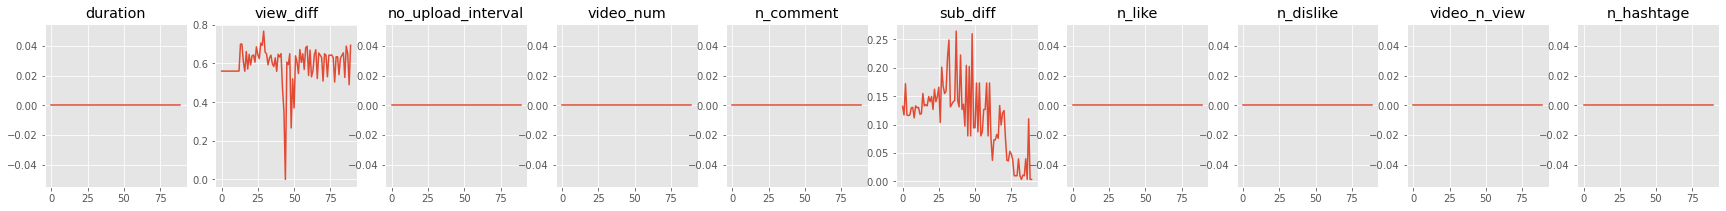

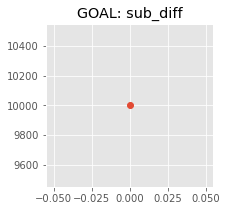

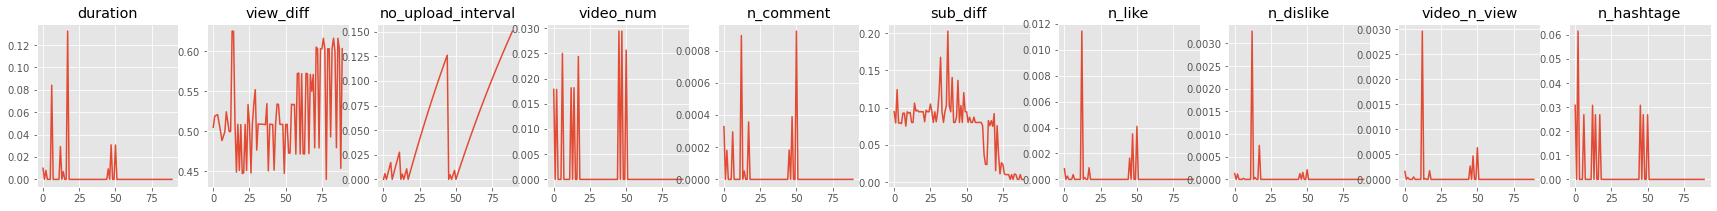

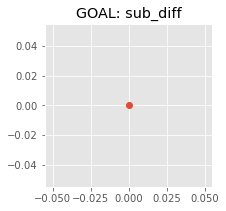

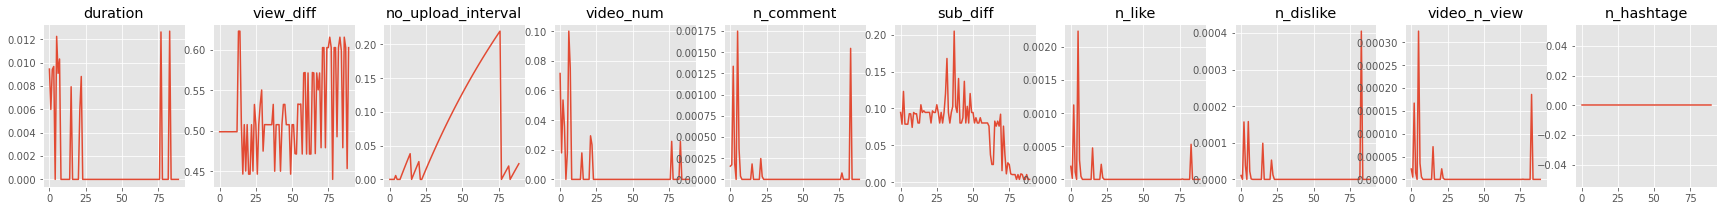

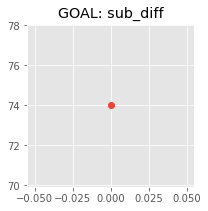

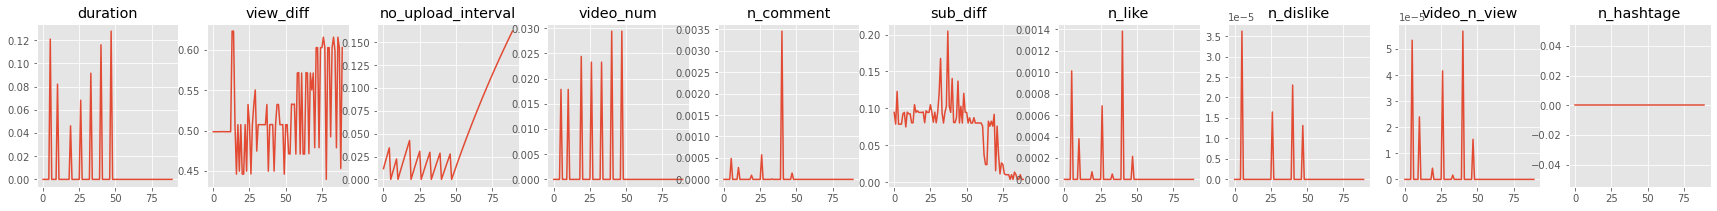

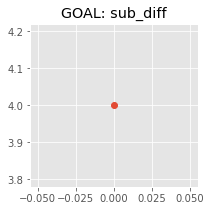

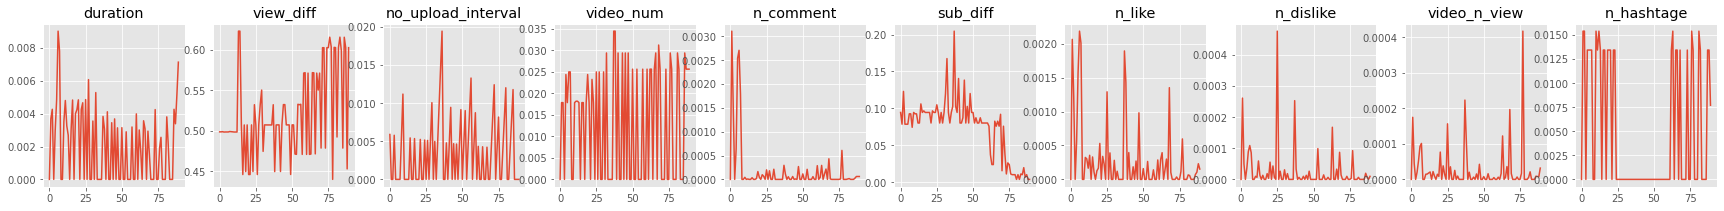

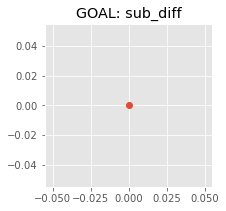

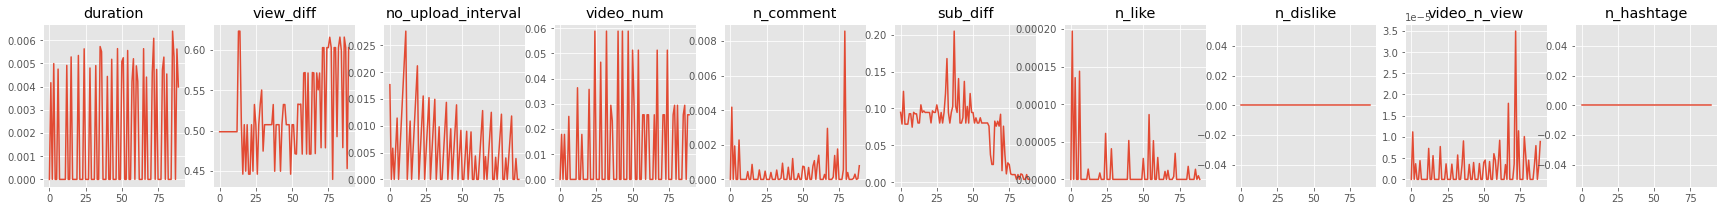

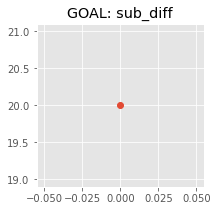

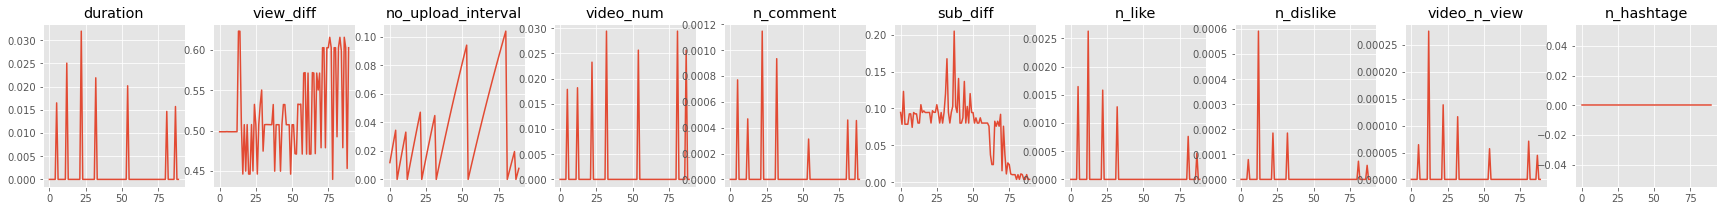

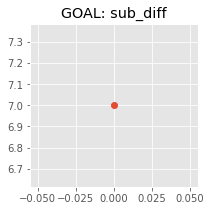

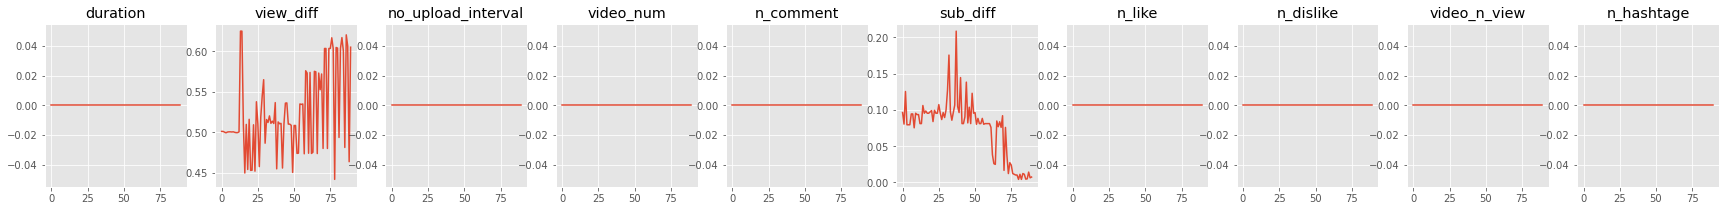

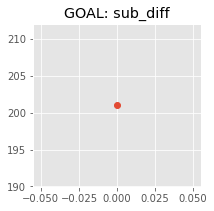

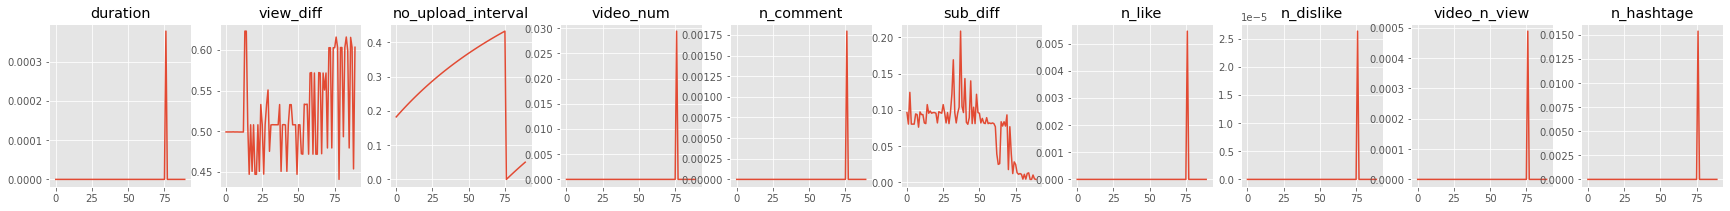

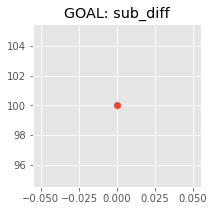

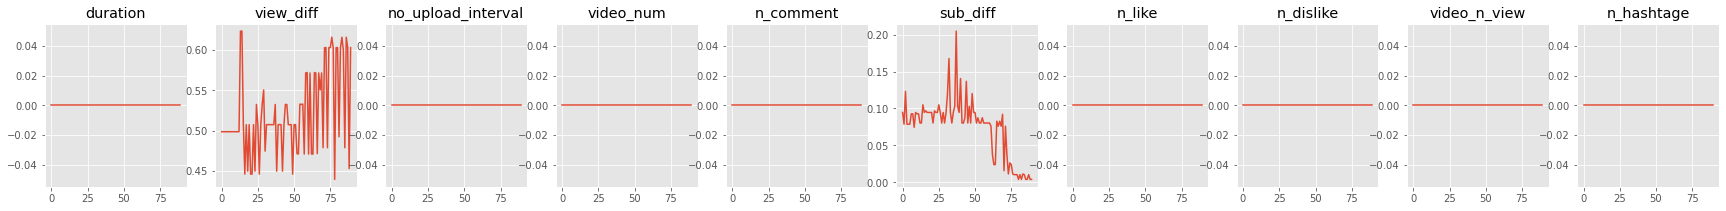

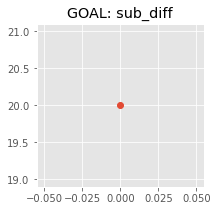

In [6]:
# 데이터 구성 살피기
import matplotlib.pyplot as plt
plt.style.use('ggplot')

h = 3 # graph's height(length)

for n in range(10): # 1부터 x_train.shape[0]까지
    fig = plt.figure(figsize=(h*len(set(X_train.columns.tolist())), h))
    for i, train_var in enumerate(set(X_train.columns.tolist())):
        plt.subplot(1, len(set(X_train.columns.tolist())), i+1)
        plt.plot(X_train[train_var].iloc[n].values)
        plt.title(str(train_var))

    fig = plt.figure(figsize=(h*len(set(y_train.columns.tolist())), h))
    for i, label_var in enumerate(set(y_train.columns.tolist())):
        plt.subplot(1, len(set(y_train.columns.tolist())), i+1)
        plt.plot(y_train[label_var].iloc[n], marker='o')
        plt.title("GOAL: " + str(label_var))
        
    plt.show()

In [7]:
n1 = 10 # number of train features
n2 = 1 # number of target features

x_train_copy = X_train.fillna(0).values.reshape(X_train.shape[0], n1, -1)
y_train_copy = y_train.fillna(0).values.reshape(y_train.shape[0], n2, -1)
x_val_copy = X_valid.fillna(0).values.reshape(X_valid.shape[0], n1, -1)
y_val_copy = y_valid.fillna(0).values.reshape(y_valid.shape[0], n2, -1)
x_test_copy = X_test.fillna(0).values.reshape(X_test.shape[0], n1, -1)
y_test_copy = y_test.fillna(0).values.reshape(y_test.shape[0], n2, -1)

In [8]:
print("x_train_copy's shape: ", x_train_copy.shape) 
print("y_train_copy's shape: ", y_train_copy.shape) 
print("x_val_copy's shape: ", x_val_copy.shape)
print("y_val_copy's shape: ", y_val_copy.shape)
print("x_test_copy's shape: ", x_test_copy.shape)
print("y_test_copy's shape: ", y_test_copy.shape)

x_train_copy's shape:  (65849, 10, 90)
y_train_copy's shape:  (65849, 1, 1)
x_val_copy's shape:  (16463, 10, 90)
y_val_copy's shape:  (16463, 1, 1)
x_test_copy's shape:  (20579, 10, 90)
y_test_copy's shape:  (20579, 1, 1)


In [9]:
# 모델 만들기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

filters = len(features)
output_num = len(target_features)

model = Sequential()
model.add(TimeDistributed(Dense(128, activation='softmax'),
          input_shape=(x_train_copy.shape[-2:])))
model.add(LSTM(units=64, return_sequences=True))
#model.add(TimeDistributed(Dense(16, activation='softmax')))
#model.add(TimeDistributed(Dense(4, activation='softmax')))
#model.add(TimeDistributed(Dense(1, activation='softmax')))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(16))
model.add(Dense(4))
model.add(Dense(output_num))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=['mae'],
              metrics=[tf.keras.metrics.RootMeanSquaredError()],
              optimizer=Adam(lr=0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 128)           11648     
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            49408     
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                41024     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5

In [10]:
# 기록하기
import time

filename='rnn_{}_{}_{}.h5'.format(filter_size, target_size, stride)

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 #tf.keras.callbacks.TensorBoard(log_dir='TensorBoard/rnn/{}'.format(time.asctime())),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5),
                 #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                 #                                     factor=0.1,
                 #                                     min_lr=1e-4, 
                 #                                     patience=0)
                ]

EPOCHS = 100
BATCH_SIZE = 32 

history2 = model.fit(x_train_copy, y_train_copy,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(x_val_copy, y_val_copy),
                     callbacks=callback_list)

Train on 65849 samples, validate on 16463 samples
Epoch 1/100
65824/65849 [============================>.] - ETA: 0s - loss: 331.2932 - root_mean_squared_error: 1873.4664
Epoch 00001: val_loss improved from inf to 353.15658, saving model to Checkpoint/rnn_90_90_1.h5
65849/65849 [==============================] - 144s 2ms/sample - loss: 331.4505 - root_mean_squared_error: 1873.5514 - val_loss: 353.1566 - val_root_mean_squared_error: 3135.1296
Epoch 2/100
65824/65849 [============================>.] - ETA: 0s - loss: 331.3215 - root_mean_squared_error: 1873.3678
Epoch 00002: val_loss improved from 353.15658 to 353.15202, saving model to Checkpoint/rnn_90_90_1.h5
65849/65849 [==============================] - 154s 2ms/sample - loss: 331.4426 - root_mean_squared_error: 1873.5441 - val_loss: 353.1520 - val_root_mean_squared_error: 3135.1211
Epoch 3/100
65824/65849 [============================>.] - ETA: 0s - loss: 331.3714 - root_mean_squared_error: 1873.4696
Epoch 00003: val_loss did not i

Epoch 43/100
65792/65849 [============================>.] - ETA: 0s - loss: 297.3543 - root_mean_squared_error: 1741.2390
Epoch 00043: val_loss did not improve from 318.30956
65849/65849 [==============================] - 114s 2ms/sample - loss: 297.3184 - root_mean_squared_error: 1740.6194 - val_loss: 318.3292 - val_root_mean_squared_error: 3058.6313
Epoch 44/100
65824/65849 [============================>.] - ETA: 0s - loss: 297.1717 - root_mean_squared_error: 1740.8054
Epoch 00044: val_loss improved from 318.30956 to 317.95530, saving model to Checkpoint/rnn_90_90_1.h5
65849/65849 [==============================] - 114s 2ms/sample - loss: 297.1885 - root_mean_squared_error: 1740.5662 - val_loss: 317.9553 - val_root_mean_squared_error: 3056.1650
Epoch 45/100
65824/65849 [============================>.] - ETA: 0s - loss: 296.8850 - root_mean_squared_error: 1738.5785
Epoch 00045: val_loss did not improve from 317.95530
65849/65849 [==============================] - 114s 2ms/sample - los

Epoch 65/100
65792/65849 [============================>.] - ETA: 0s - loss: 295.3085 - root_mean_squared_error: 1724.3857
Epoch 00065: val_loss improved from 314.83042 to 314.59568, saving model to Checkpoint/rnn_90_90_1.h5
65849/65849 [==============================] - 117s 2ms/sample - loss: 295.3618 - root_mean_squared_error: 1724.6060 - val_loss: 314.5957 - val_root_mean_squared_error: 3046.5977
Epoch 66/100
65824/65849 [============================>.] - ETA: 0s - loss: 295.3789 - root_mean_squared_error: 1724.6498
Epoch 00066: val_loss did not improve from 314.59568
65849/65849 [==============================] - 119s 2ms/sample - loss: 295.3322 - root_mean_squared_error: 1724.3407 - val_loss: 314.7413 - val_root_mean_squared_error: 3046.3838
Epoch 67/100
65824/65849 [============================>.] - ETA: 0s - loss: 295.2442 - root_mean_squared_error: 1723.8810
Epoch 00067: val_loss improved from 314.59568 to 314.52050, saving model to Checkpoint/rnn_90_90_1.h5
65849/65849 [======

In [11]:
UPDATED_EPOCHS = 77 + 1

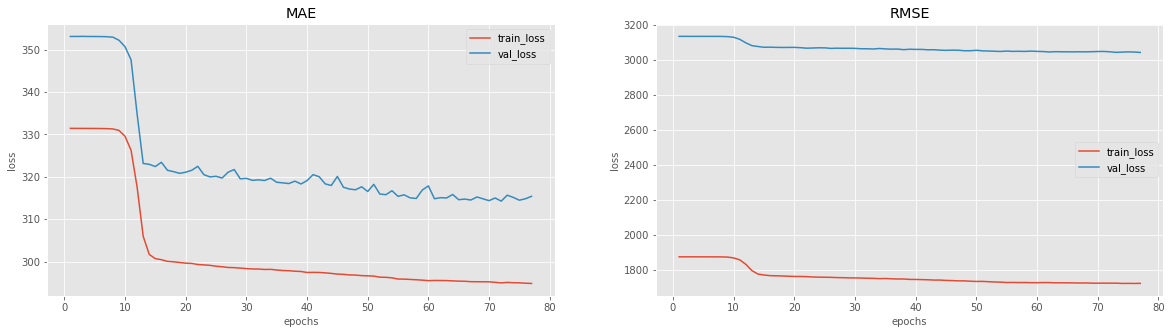

In [12]:
## 모델 성능 그래프로 나타내기

import numpy as np

epochs = np.arange(1, UPDATED_EPOCHS)
fig, axes = plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history2.history['loss'], label='train_loss')
plt.plot(epochs, history2.history['val_loss'], label='val_loss')
plt.xlabel('epochs', fontdict={'size': 10})
plt.ylabel('loss', fontdict={'size': 10})
plt.title("MAE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history2.history['root_mean_squared_error'], label='train_loss')
plt.plot(epochs, history2.history['val_root_mean_squared_error'], label='val_loss')
plt.xlabel('epochs', fontdict={'size': 10})
plt.ylabel('loss', fontdict={'size': 10})
plt.title("RMSE")
plt.legend()

plt.show()

In [13]:
# 모델 저장하고 복원하기
from tensorflow.keras.models import load_model

filename = 'rnn_{}_{}_{}.h5'.format(filter_size, target_size, stride)

model.save('Model/{}'.format(filename))
res_model = load_model('Model/{}'.format(filename))
res_model.load_weights('Model/{}'.format(filename))
#res_model.evaluate(x_test_copy, y_test_copy)
mae, rmse = model.evaluate(x_test_copy, y_test_copy, verbose=2)
print("MAE of Untrained Model: {:5.2f}%".format(mae))
print("RMSE of Untrained Model: {:5.2f}%".format(rmse))

20579/1 - 9s - loss: 174.5915 - root_mean_squared_error: 2987.5500
MAE of Untrained Model: 318.84%
RMSE of Untrained Model: 2987.55%


In [19]:
mae

318

In [14]:
# 테스트 세트로 예측하기
test_predict = model.predict(x_test_copy)

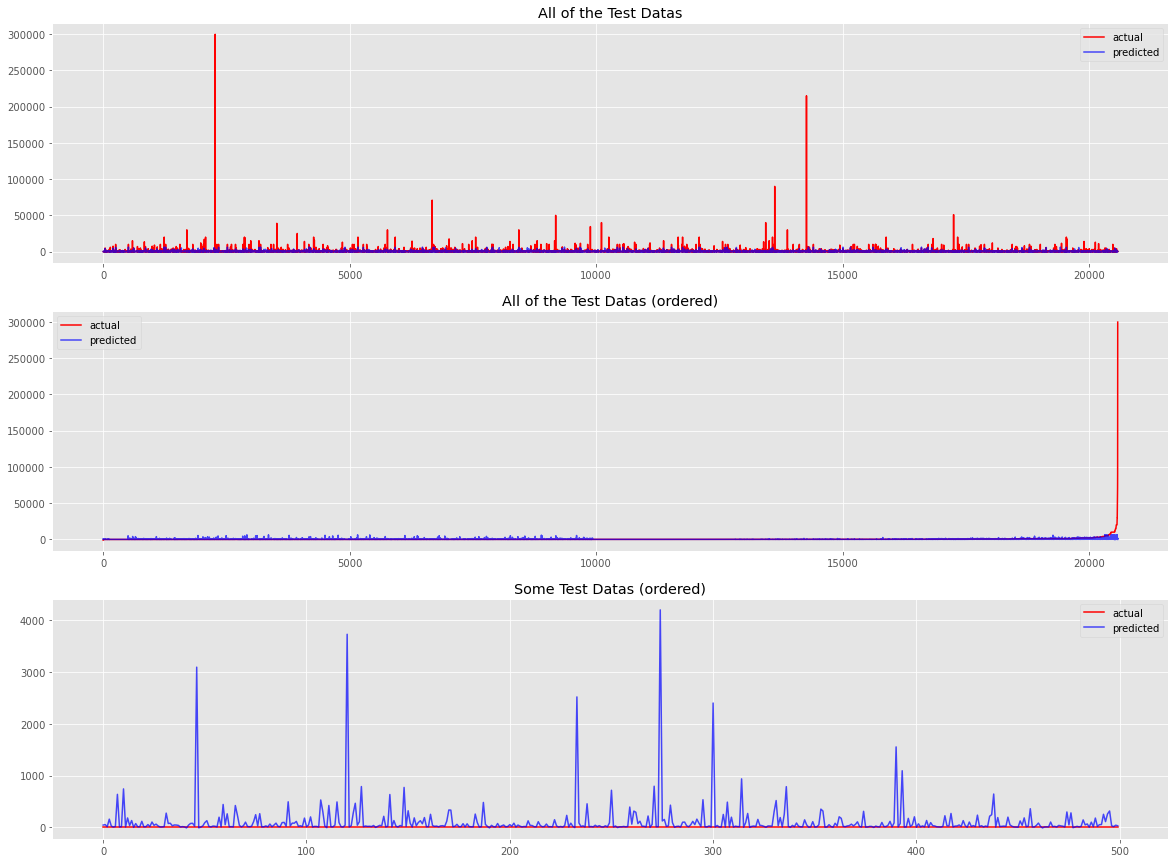

In [15]:
# 예측한 것 시각화하기 (한 개 다 합친 것)

actual = pd.DataFrame(y_test_copy[:,0,0], columns=['actual'])
pred = pd.DataFrame(test_predict[:,0], columns=['pred'])
result = pd.concat([actual, pred], axis=1)
ord_result = result.sort_values(by=['actual']) # 순차적으로
start, end = 7500, 8000
my_result = ord_result.iloc[start:end] # 보고 싶은 범위만

fig, axes = plt.subplots(figsize=(20, 15))

plt.subplot(3, 1, 1)
total = [j for j in range(y_test_copy.shape[0])]
plt.plot(total, result['actual'], 'r', label='actual')
plt.plot(total, result['pred'], 'b', label='predicted', alpha=0.7)
plt.title("All of the Test Datas")
plt.legend()

plt.subplot(3, 1, 2)
total = [j for j in range(ord_result.shape[0])]
plt.plot(total, ord_result['actual'], 'r', label='actual')
plt.plot(total, ord_result['pred'], 'b', label='predicted', alpha=0.7)
plt.title("All of the Test Datas (ordered)")
plt.legend()

plt.subplot(3, 1, 3)
total = [j for j in range(my_result.shape[0])]
plt.plot(total, my_result['actual'], 'r', label='actual')
plt.plot(total, my_result['pred'], 'b', label='predicted', alpha=0.7)
plt.title("Some Test Datas (ordered)")
plt.legend()

plt.show()

total test samples: 20579 개
good mae result / total result (%): 84.06


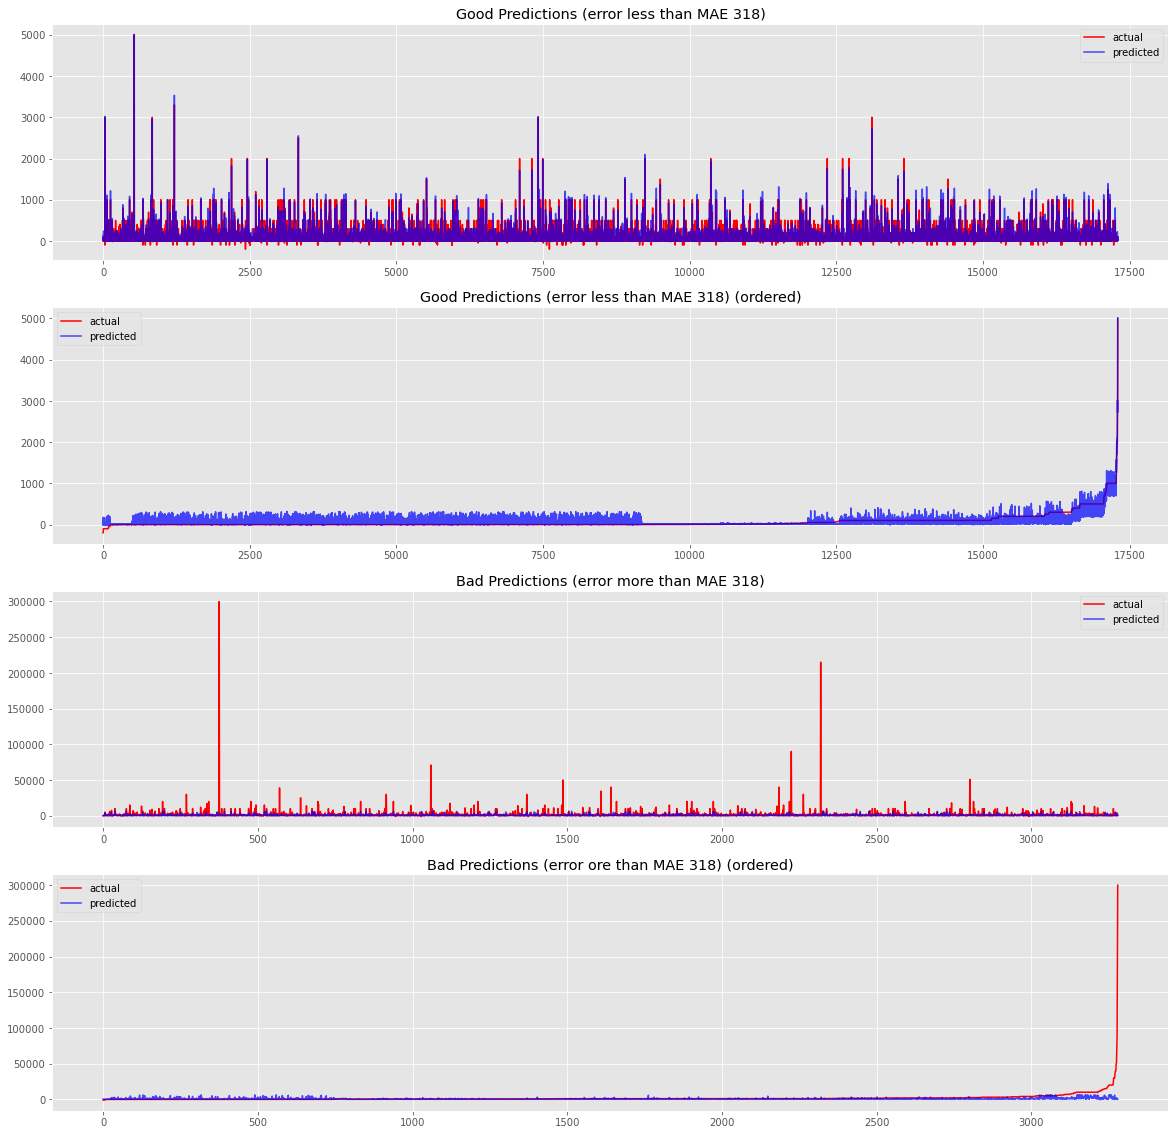

In [16]:
good_a, good_p, bad_a, bad_p = [], [], [], []
mae = int(mae)

for i in range(result.shape[0]):
    a = result['actual'].iloc[i]
    p = result['pred'].iloc[i]

    if abs(a-p) <= mae:
        good_a.append(a)
        good_p.append(p)
    else:
        bad_a.append(a)
        bad_p.append(p)

good_a = pd.DataFrame(good_a, columns=['actual'])
good_p = pd.DataFrame(good_p, columns=['pred'])
good_result = pd.concat([good_a, good_p], axis=1)
good_ord_result = good_result.sort_values(by=['actual']) # 순차적으로

bad_a = pd.DataFrame(bad_a, columns=['actual'])
bad_p = pd.DataFrame(bad_p, columns=['pred'])
bad_result = pd.concat([bad_a, bad_p], axis=1)
bad_ord_result = bad_result.sort_values(by=['actual']) # 순차적으로

print("total test samples:", result.shape[0], "개")
per_mae = np.round((good_result.shape[0]/result.shape[0])*100, 2)
print("good mae result / total result (%):", per_mae)

fig, axes = plt.subplots(figsize=(20, 20)) # Test MAE보다 작거나 같은 것만

plt.subplot(4, 1, 1)
total = [j for j in range(good_result.shape[0])]
plt.plot(total, good_result['actual'], 'r', label='actual')
plt.plot(total, good_result['pred'], 'b', label='predicted', alpha=0.7)
plt.legend()
plt.title("Good Predictions (error less than MAE {}".format(mae)+ ")")

plt.subplot(4, 1, 2)
total = [j for j in range(good_ord_result.shape[0])]
plt.plot(total, good_ord_result['actual'], 'r', label='actual')
plt.plot(total, good_ord_result['pred'], 'b', label='predicted', alpha=0.7)
plt.legend()
plt.title("Good Predictions (error less than MAE {}".format(mae)+ ") (ordered)")

plt.subplot(4, 1, 3)
total = [j for j in range(bad_result.shape[0])]
plt.plot(total, bad_result['actual'], 'r', label='actual')
plt.plot(total, bad_result['pred'], 'b', label='predicted', alpha=0.7)
plt.legend()
plt.title("Bad Predictions (error more than MAE {}".format(mae)+ ")")

plt.subplot(4, 1, 4)
total = [j for j in range(bad_ord_result.shape[0])]
plt.plot(total, bad_ord_result['actual'], 'r', label='actual')
plt.plot(total, bad_ord_result['pred'], 'b', label='predicted', alpha=0.7)
plt.legend()
plt.title("Bad Predictions (error ore than MAE {}".format(mae)+ ") (ordered)")

plt.show()

In [17]:
start = 10000
end = 20000

column_classes = X.columns.unique().tolist()
channel = pd.DataFrame(scaler.transform(X.loc[start:end, :]), columns=X.columns)
channel_list = channel.values.reshape(channel.shape[0], -1, filter_size) # (end-start, features, filters)

channel_real = y.loc[start:end, :].values.flatten() # (end-start, 1)
channel_pred = model.predict(channel_list).flatten() # (end-start, 1)
pred = pd.DataFrame(dict(real=channel_real, pred=channel_pred))

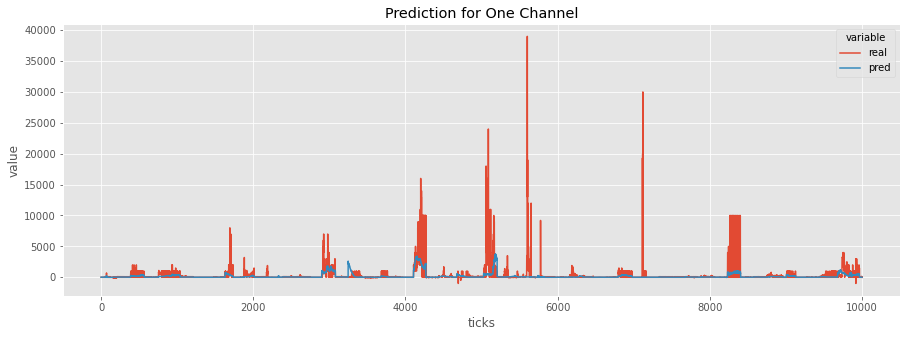

In [18]:
import seaborn as sns

plt.figure(figsize=(15, 5))
to_plot = pred.melt()
to_plot['ticks'] = [i for i in range(pred.shape[0])] * 2
sns.lineplot(x='ticks', y='value', hue='variable', data=to_plot)
plt.title('Prediction for One Channel')
plt.show()